In [10]:
import os, shutil, torch
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Spacingd,
    MapTransform,
    ToTensord,
    ConcatItemsd,
    RandSpatialCropd,
    CenterSpatialCropd,
    RandSpatialCropSamplesd,
    SpatialPadd,
    RandCropByLabelClassesd
)
from monai.data import Dataset, DataLoader
import nibabel as nib
import numpy as np 
from monai import transforms, data
import matplotlib.pyplot as plt 

class ConvertLabelBasedOnClasses(MapTransform):
    def __call__(self, data):
        d = dict(data)
        # print(data)
        for key in self.keys:
            result = d[key] > 1
            d[key] = result.float()
        return d

class DeleteDataKeysd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            del d[key]
        return d
    
def find_bbox(seg):
    x_start, x_end = np.where(np.any(seg, axis=(1, 2)))[0][[0, -1]]
    y_start, y_end = np.where(np.any(seg, axis=(0, 2)))[0][[0, -1]]
    z_start, z_end = np.where(np.any(seg, axis=(0, 1)))[0][[0, -1]]

    return (x_start, x_end, y_start, y_end, z_start, z_end)

PAIs001 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.7121823 2.6577106


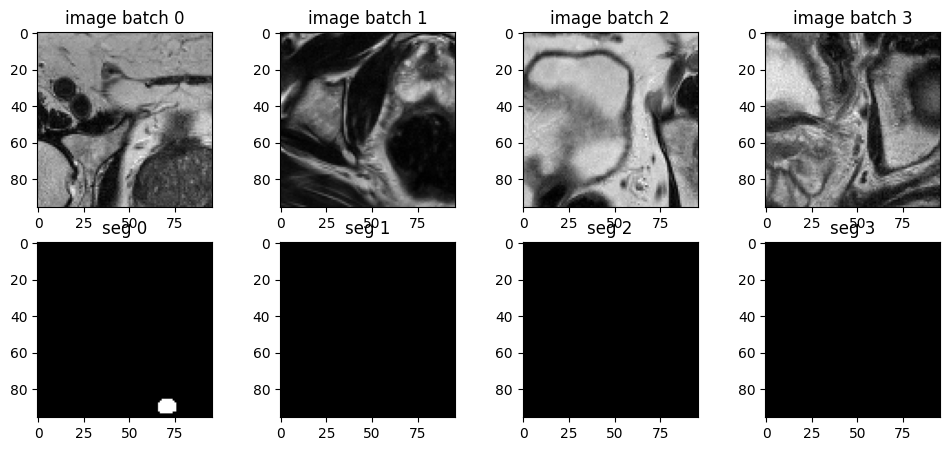

PAIs007 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.3073075 3.9017115


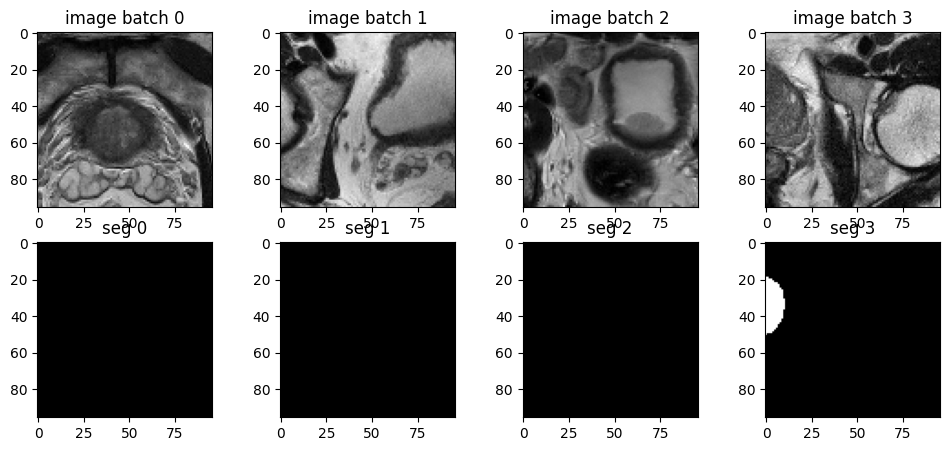

PAIs013 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.458002 2.9386888


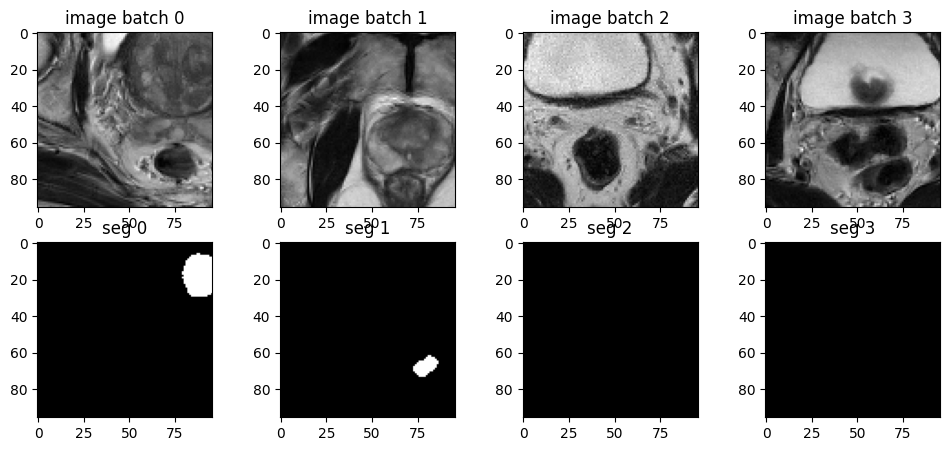

PAIs018 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.708108 4.3099847


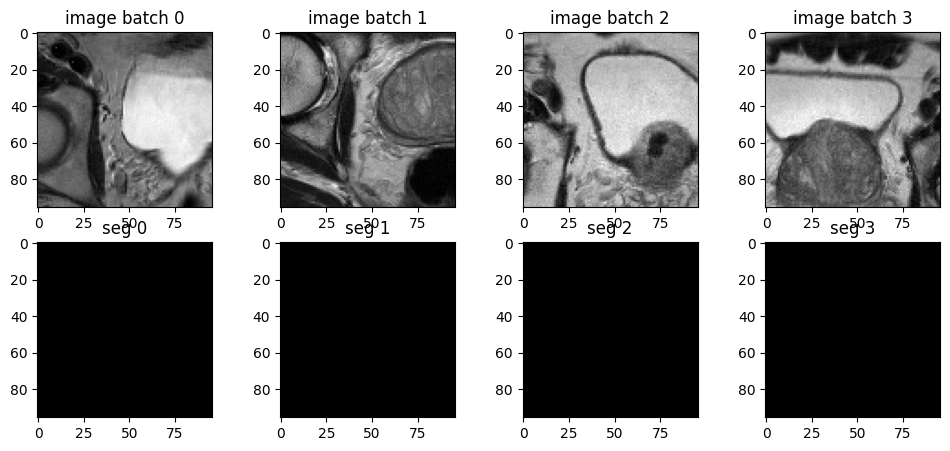

PAIs023 torch.Size([4, 1, 96, 96, 32]) torch.Size([4, 1, 96, 96, 32]) 1.0 -1.1128726 3.816324


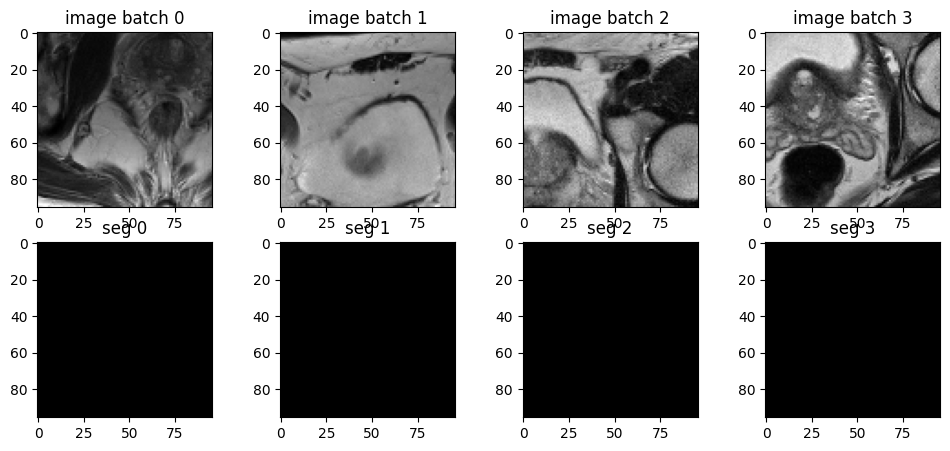

In [15]:
x, y, z = 96, 96, 32
B = 4
modality = 'T2W'
tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"

train_samples = []
with open(f'./{modality}.txt', 'r') as f:
    lines = f.readlines()
    for name in lines:
        name = name.strip()
        sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz'),
                    "image": os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')}
        train_samples.append(sample)
test_samples = []
with open('./cspca_test.txt', 'r') as f:
    lines = f.readlines()
    for name in lines:
        name = name.strip()
        sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz'),
                    "image": os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')}
        test_samples.append(sample)

train_transform = Compose(
    [        
        # load single modality
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandSpatialCropSamplesd(keys=["image", "label"], roi_size=[x, y, z], num_samples=1, random_size=False),
        ToTensord(keys=["image", "label"]),
    ]
)

train_ds = Dataset(data=train_samples, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=False, num_workers=0)

for idx, check_data in enumerate(train_loader):
    name = check_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_data['image']
    label = check_data['label']
    print(name, img.shape, label.shape, np.max(label), np.min(img[0]), np.max(img[0]))
    # break
    plt.figure(figsize=(3*B, 5))
    for i in range(B):
        plt.subplot(2, B, i+1)
        plt.title(f"image batch {i}")
        plt.imshow(img[i,0,...,31].detach().cpu(), cmap="gray")

        plt.subplot(2, B, i+1+B)
        plt.title(f"seg {i}")
        plt.imshow(label[i][0,...,31].detach().cpu(), cmap="gray")
    plt.show()
    if idx == 4:
        break

In [ ]:
x, y, z = 96, 96, 32
B = 4
modality = 'T2W'
tiantian_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
name_list = os.listdir(tiantian_root)
datalist = []
for name in name_list:
    sample = {"label": os.path.join(tiantian_root, name, f'{name}_{modality}_gt.nii.gz')}
    sample["image"] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')

    for modality in ['T2W', 'DWI', 'ADC']:
        sample[modality] = os.path.join(tiantian_root, name, f'{name}_{modality}.nii.gz')
    datalist.append(sample)

train_transform = Compose(
    [
        ## load 4 Nifti images and stack them together
        # LoadImaged(keys=["T2W", "DWI", "ADC", "label"]),
        # EnsureTyped(keys=["T2W", "DWI", "ADC", "label"]),
        # ConvertLabelBasedOnClasses(keys="label"),
        # EnsureChannelFirstd(keys=["T2W", "DWI", "ADC", "label"]),
        # ConcatItemsd(keys=["T2W", "DWI", "ADC"], name="image"),
        
        # load single modality
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),

        # Orientationd(keys=["image", "label"], axcodes="RAS"),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[x, y, z]),
        RandCropByLabelClassesd(
                keys=["image", "label"],
                label_key="label",
                spatial_size=[x, y, z],
                num_classes=2,
                ratios=[0,1],
                num_samples=1,
            ),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=0),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=1),
        # RandFlipd(keys=["image", "label"], prob=0.1, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        # RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
        # RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
        ToTensord(keys=["image", "label"]),
        # DeleteDataKeysd(keys=["T2W", "DWI", "ADC"]),
    ]
)
train_ds = Dataset(data=datalist, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=B, shuffle=False, num_workers=0)

for idx, check_data in enumerate(train_loader):
    name = check_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_data['image']
    label = check_data['label']
    print(name, img.shape, label.shape, np.max(label), np.min(img[0]), np.max(img[0]))
    # break
    plt.figure(figsize=(4*B, 8))
    for i in range(B):
        plt.subplot(2, B, i+1)
        plt.title(f"image batch {i}")
        plt.imshow(img[i,0,...,16].detach().cpu(), cmap="gray")

        plt.subplot(2, B, i+1+B)
        plt.title(f"seg {i}")
        plt.imshow(label[i,0,...,16].detach().cpu(), cmap="gray")
    plt.show()
    if idx == 1:
        break

In [28]:
# check train_loader and test loader
modality = "ADC"
file_root = "/Users/qixinhu/Project/CUHK/Prostate/PAIsData/0426/tiantian"
test_samples = []
with open('./cspca_test.txt', 'r') as f:
    lines = f.readlines()
    for name in lines:
        name = name.strip()
        sample = {"label": os.path.join(file_root, name, f'{name}_{modality}_gt.nii.gz'),
                    "image": os.path.join(file_root, name, f'{name}_{modality}.nii.gz')}
        test_samples.append(sample)


train_transform = Compose(
        [
            # load single modality
            LoadImaged(keys=["image", "label"]),
            EnsureTyped(keys=["image", "label"]),
            ConvertLabelBasedOnClasses(keys="label"),
            EnsureChannelFirstd(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="PLS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.0, 1.0, 1.0),
                mode=("bilinear", "nearest"),
            ),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[x, y, z]),
            # RandSpatialCropSamplesd(keys=["image", "label"], roi_size=[args.x, args.y, args.z], num_samples=2, random_size=False),
            # RandScaleIntensityd(keys="image", factors=0.1, prob=0.15),
            # RandShiftIntensityd(keys="image", offsets=0.1, prob=0.15),
            ToTensord(keys=["image", "label"]),
        ]
    )
    
test_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        ConvertLabelBasedOnClasses(keys="label"),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="PLS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

train_ds = Dataset(data=test_samples, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

test_ds = Dataset(data=test_samples, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# check_train = next(iter(train_loader))
# check_test = next(iter(test_loader))

for check_train in train_loader:
    name = check_train['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
    img   = check_train['image']
    print(name, img.shape)

PAIs010 torch.Size([1, 1, 166, 166, 73])
PAIs014 torch.Size([1, 1, 201, 201, 77])
PAIs053 torch.Size([1, 1, 181, 181, 64])
PAIs054 torch.Size([1, 1, 200, 200, 85])
PAIs055 torch.Size([1, 1, 201, 201, 70])
PAIs065 torch.Size([1, 1, 166, 166, 74])
PAIs075 torch.Size([1, 1, 166, 166, 82])
PAIs079 torch.Size([1, 1, 200, 200, 88])
PAIs093 torch.Size([1, 1, 201, 201, 92])
PAIs096 torch.Size([1, 1, 166, 166, 82])
PAIs101 torch.Size([1, 1, 166, 166, 70])
PAIs129 torch.Size([1, 1, 166, 166, 74])
PAIs130 torch.Size([1, 1, 166, 166, 82])
PAIs145 torch.Size([1, 1, 166, 166, 82])
PAIs210 torch.Size([1, 1, 166, 166, 82])
PAIs224 torch.Size([1, 1, 161, 161, 88])
PAIs268 torch.Size([1, 1, 251, 251, 147])
PAIs271 torch.Size([1, 1, 166, 166, 73])
PAIs272 torch.Size([1, 1, 166, 166, 73])
PAIs280 torch.Size([1, 1, 166, 166, 82])
